# imports

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr, spearmanr

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
import xgboost as xgb

/home/pelle/anaconda3/envs/py39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/pelle/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Data

In [2]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/'
df_post = pd.read_csv(p+'submissions_pmaw_2016-2021_wsb.csv',usecols=['author','created_utc','score','num_comments','title','selftext','id','award_count'])
df_post = df_post[df_post['author'] != '[deleted]']
len1=len(df_post.loc[df_post['award_count'] > 0])
len2=len(df_post.loc[df_post['award_count'] == 0])

In [3]:
p = '/home/pelle/Master_Thesis/data/raw/wallstreetbets/graph_features_2/'
file_names=os.listdir(p)

data = []

for name in file_names:
    data.append(pd.read_csv(p+name))

df_gf=pd.concat(data)

df_balanced = pd.read_csv('/home/pelle/Master_Thesis/data/raw/wallstreetbets/balanced_data_chunked10.csv')

In [4]:
df_gf.drop_duplicates(inplace=True)
df=df_balanced.join(df_gf.set_index('id'),on='id')
df.dropna(subset='degree',inplace=True)
df=df[['author', 'date', 'score', 'n_comments', 'id',
       'n_awards', 'text_title', 'degree_cen', 'close_cen', 
       'activity', 'degree', 'N_nodes', 'N_edges','mentions']]

df.loc[df.n_awards==0,'awarded']=0
df.loc[df.n_awards!=0,'awarded']=1

df['n_comments']=df.n_comments.apply(lambda x: np.sqrt(x**2))

df['date'] = pd.to_datetime(df['date'])

In [5]:
def get_sentiment(text):
    if type(text) == str:
        com = sia.polarity_scores(text)['compound']
        return com
    else:
        return np.nan

def text_length(text):
    if type(text) == str:
        return len(text)
    else:
        return np.nan

df['sentiment_compound']=df['text_title'].apply(lambda x: get_sentiment(x))
df['text_length']=df['text_title'].apply(lambda x: text_length(x))

In [6]:
# drop AutoModerater posts
df=df[df.author!='AutoModerator']

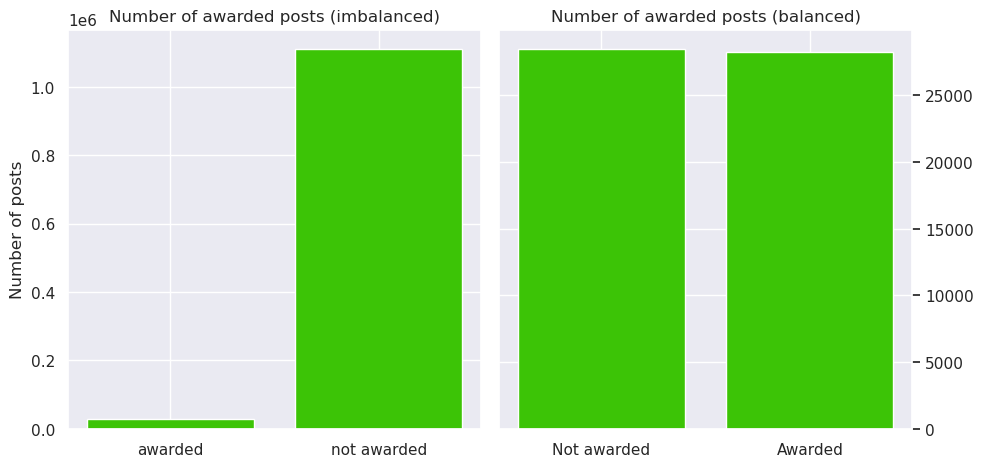

In [7]:
# subplots
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].bar(['awarded','not awarded'],[len1,len2],color='#3cc406')
ax[0].set_title('Number of awarded posts (imbalanced)')
ax[0].set_ylabel('Number of posts')
ax[1].bar(['Not awarded','Awarded'],df.awarded.value_counts(),color='#3cc406')
ax[1].set_title('Number of awarded posts (balanced)')
# ax[1].set_ylabel('Number of posts')
# set y axis on the right
ax[1].yaxis.tick_right()
plt.tight_layout()
plt.show()

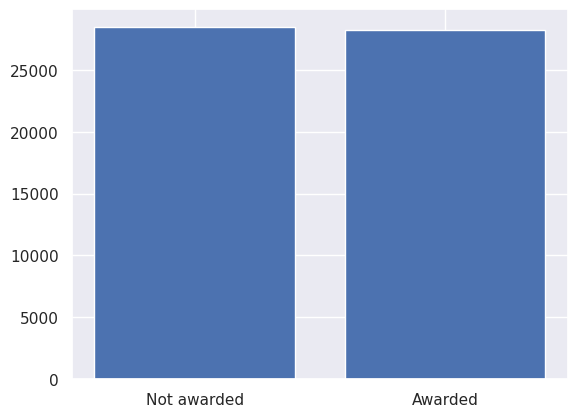

Data size: 56738


In [8]:
plt.bar(['Not awarded','Awarded'],df.awarded.value_counts())
plt.show()
print('Data size: ' + str(len(df)))

# Analysis

In [9]:
df_no = df.loc[df.degree!=0]

### Temporal

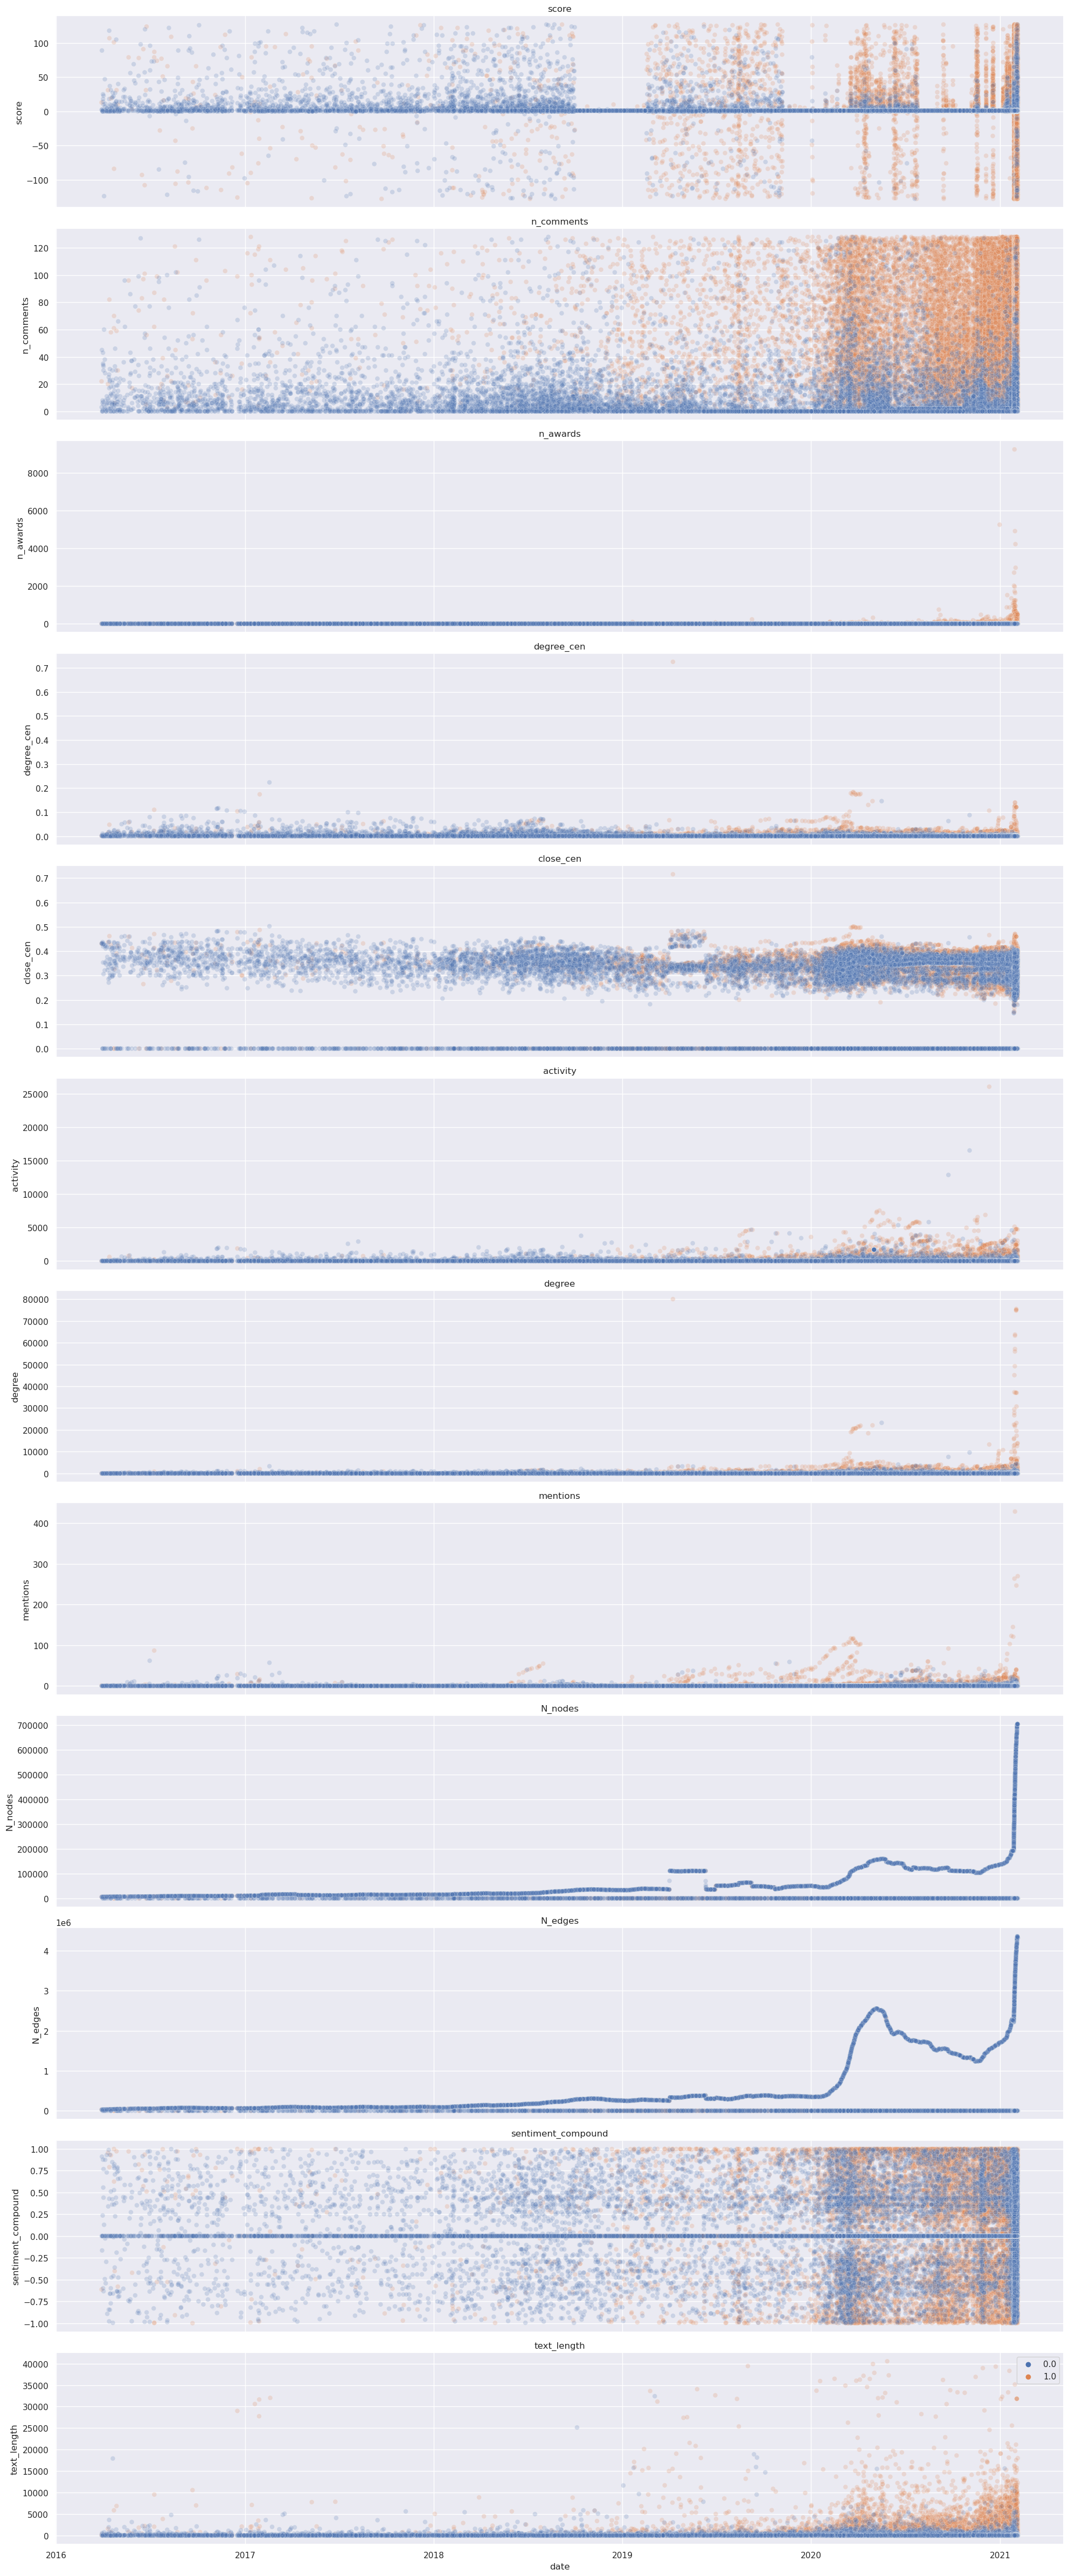

In [10]:
# subplots share x
features =['score', 'n_comments','n_awards','degree_cen', 'close_cen', 'activity', 'degree', 'mentions', 'N_nodes', 'N_edges','sentiment_compound','text_length']
fig, axs = plt.subplots(len(features), 1, figsize=(20,4*len(features)), sharex=True)


for val in features:
    sns.scatterplot(data=df, x='date', y=val, hue='awarded', ax=axs[features.index(val)], alpha=0.2,s=40)
    axs[features.index(val)].set_title(val)
    # legend false
    axs[features.index(val)].get_legend().remove()

plt.legend()
plt.tight_layout()
plt.show()

/tmp/ipykernel_15669/2044972228.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  rho = df.corr()
/tmp/ipykernel_15669/2044972228.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)


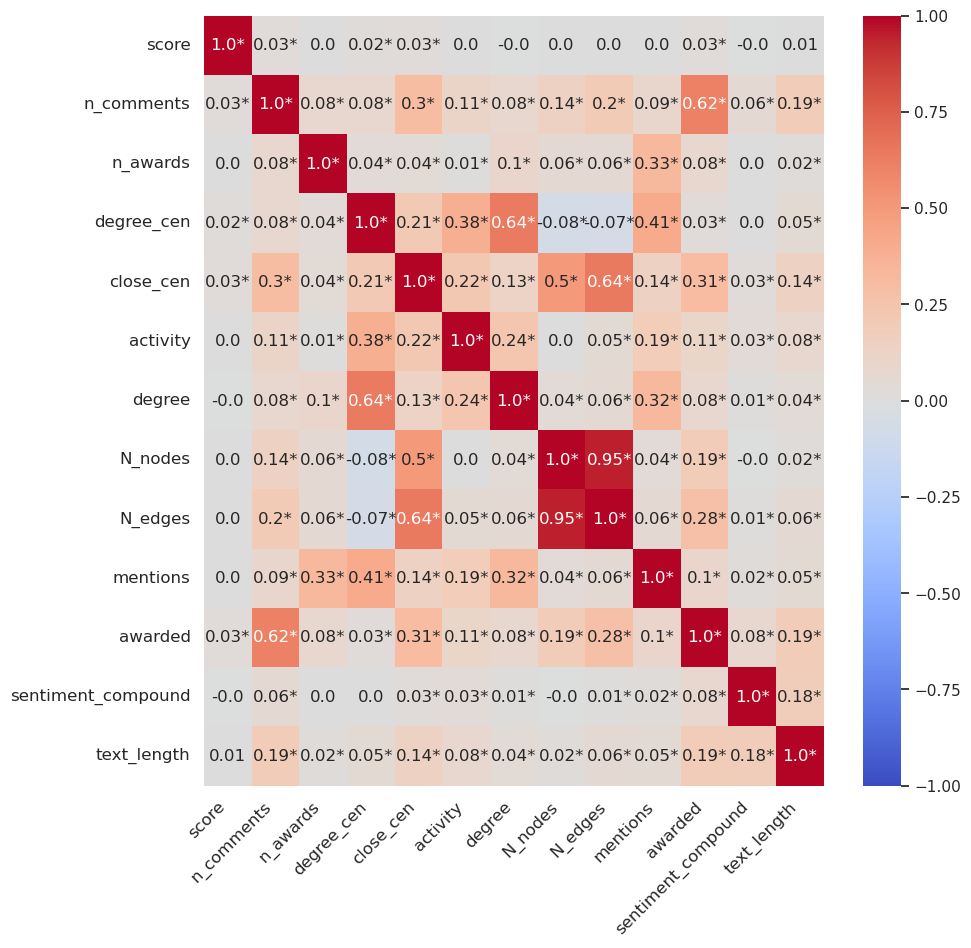

In [11]:
rho = df.corr()
pval = df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t]))

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(data=rho, annot=(np.array(rho.round(2).astype(str) + p)),fmt = '',vmin=-1,vmax=1,cmap='coolwarm')

# rotate xticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12)
plt.savefig('correlation_matrix.png',dpi=300)
plt.show()

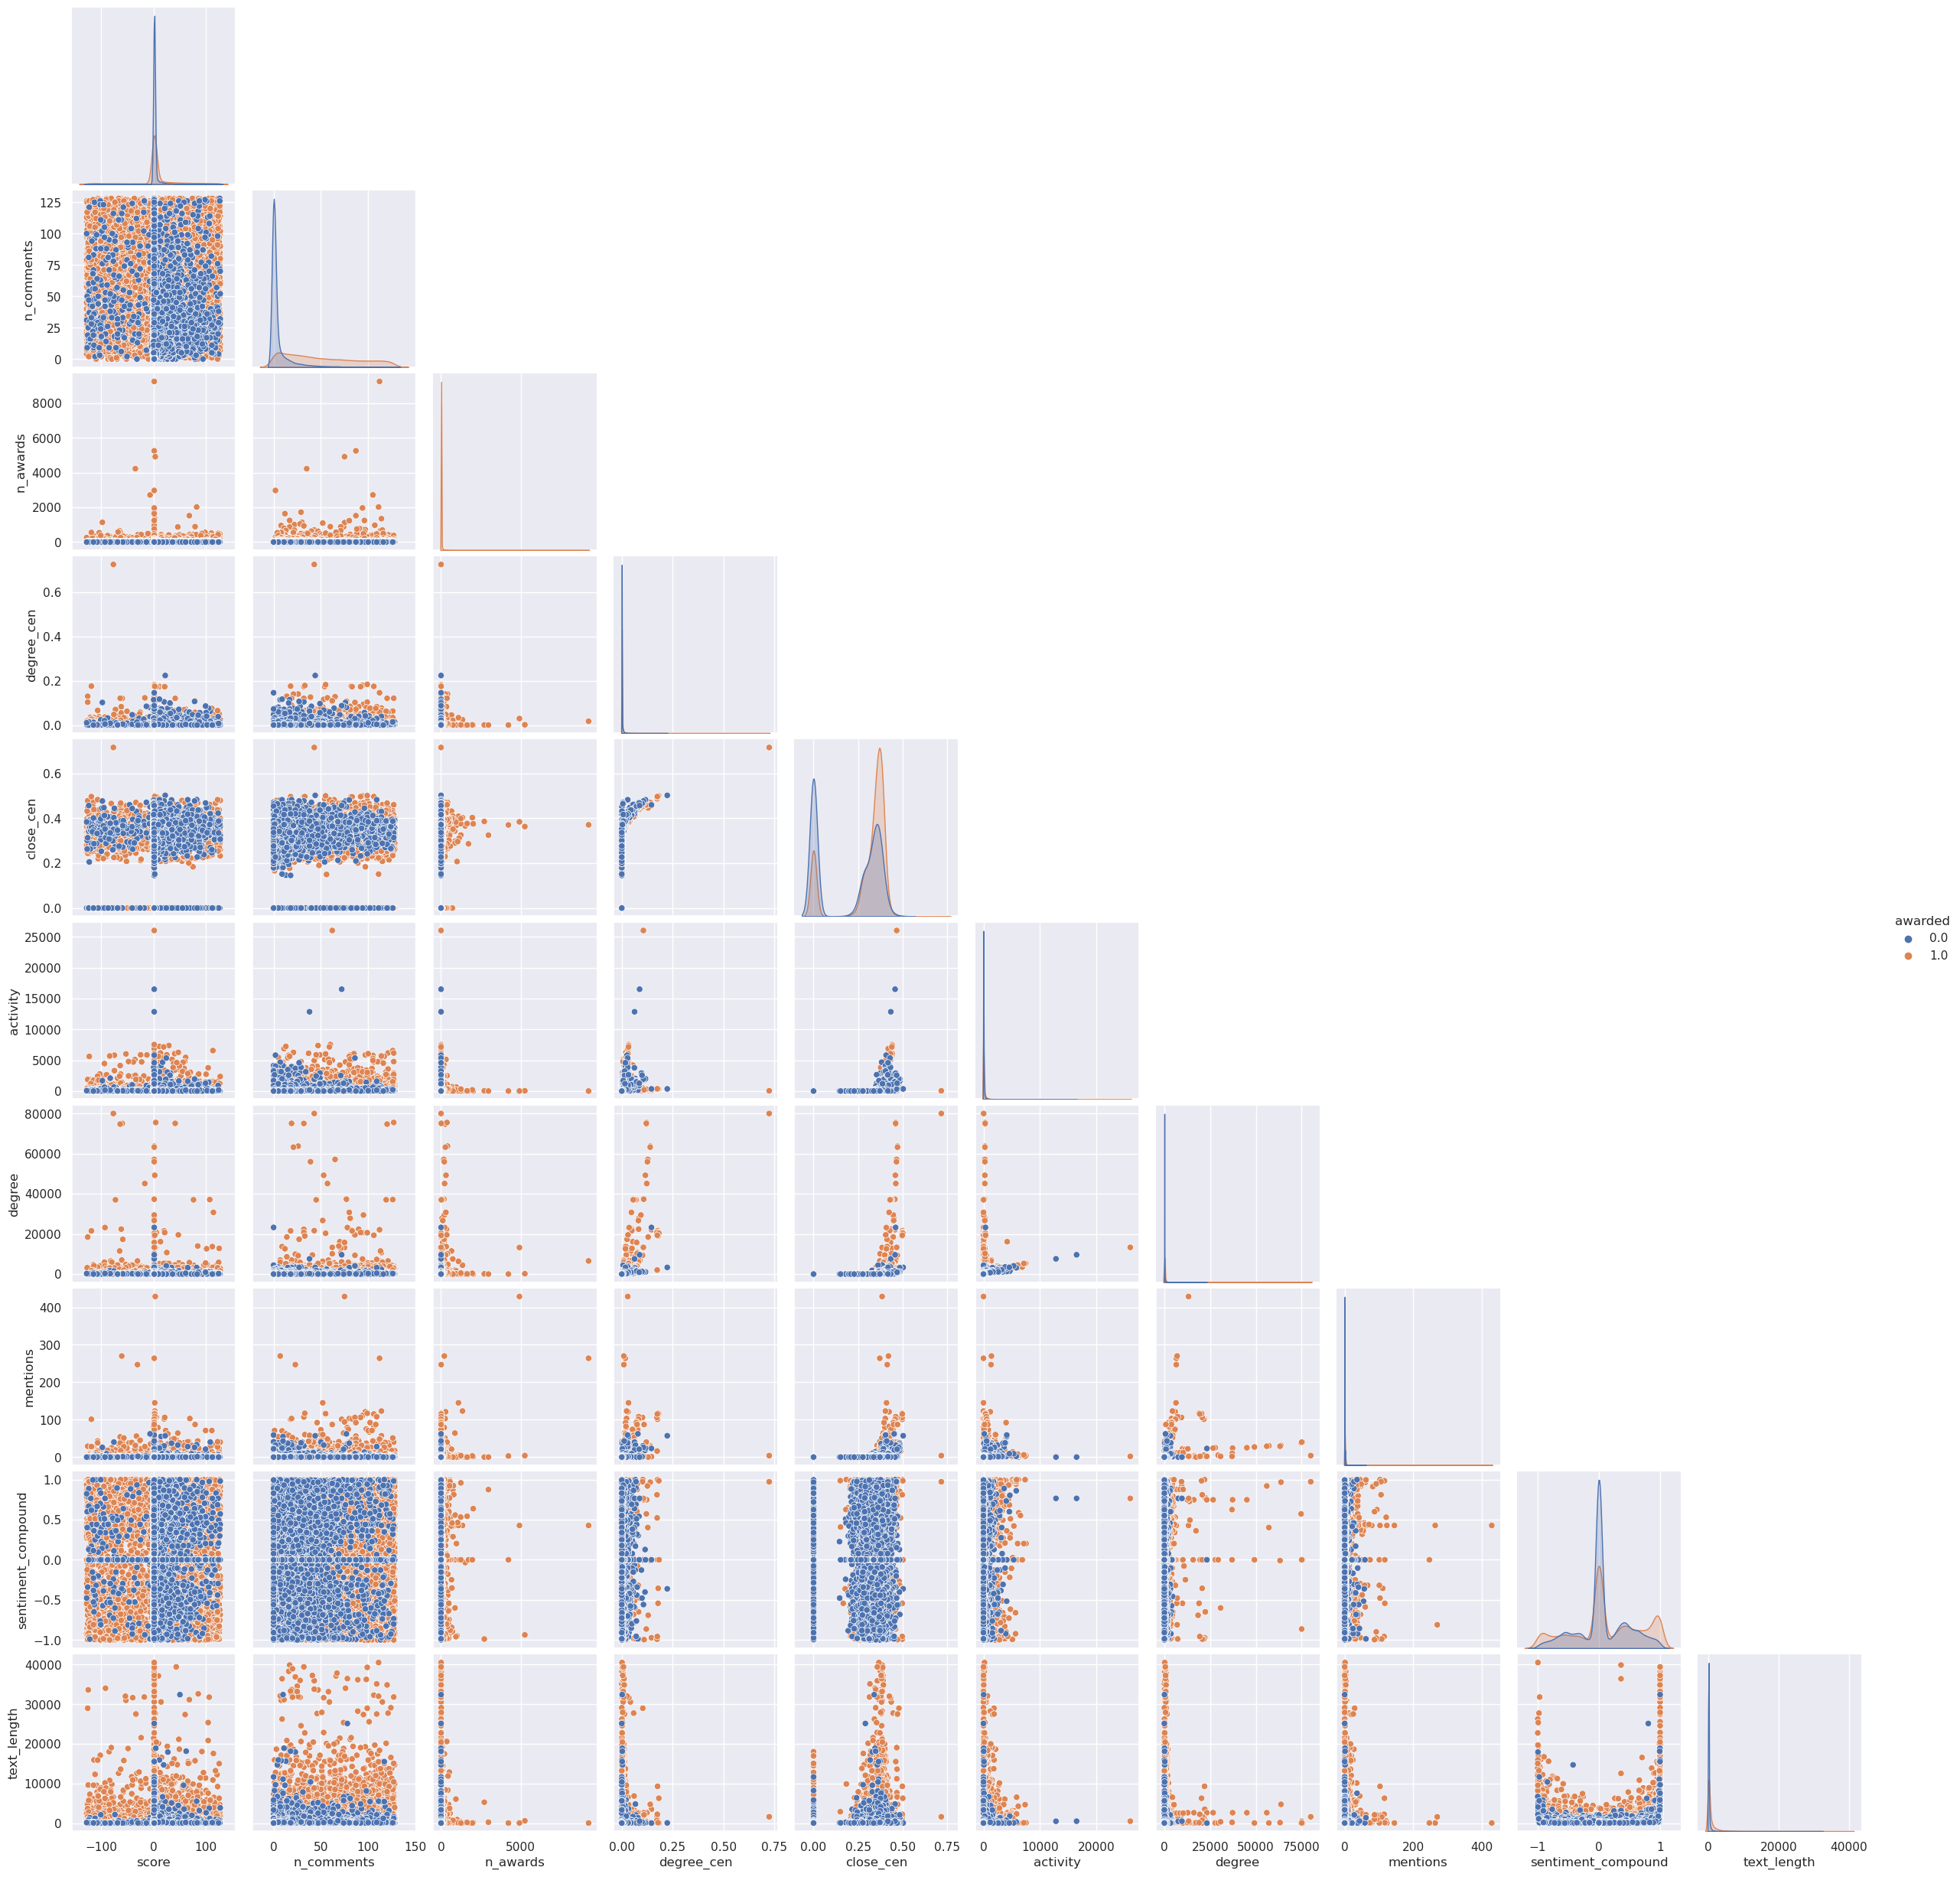

In [12]:
sns.pairplot(df, hue='awarded', vars=['score', 'n_comments','n_awards','degree_cen', 
                                    'close_cen', 'activity', 'degree', 'mentions', 
                                    'sentiment_compound','text_length'],corner=True)

/tmp/ipykernel_15669/612211926.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_no, x=f, hue='awarded', fill=True, ax=axs[i])


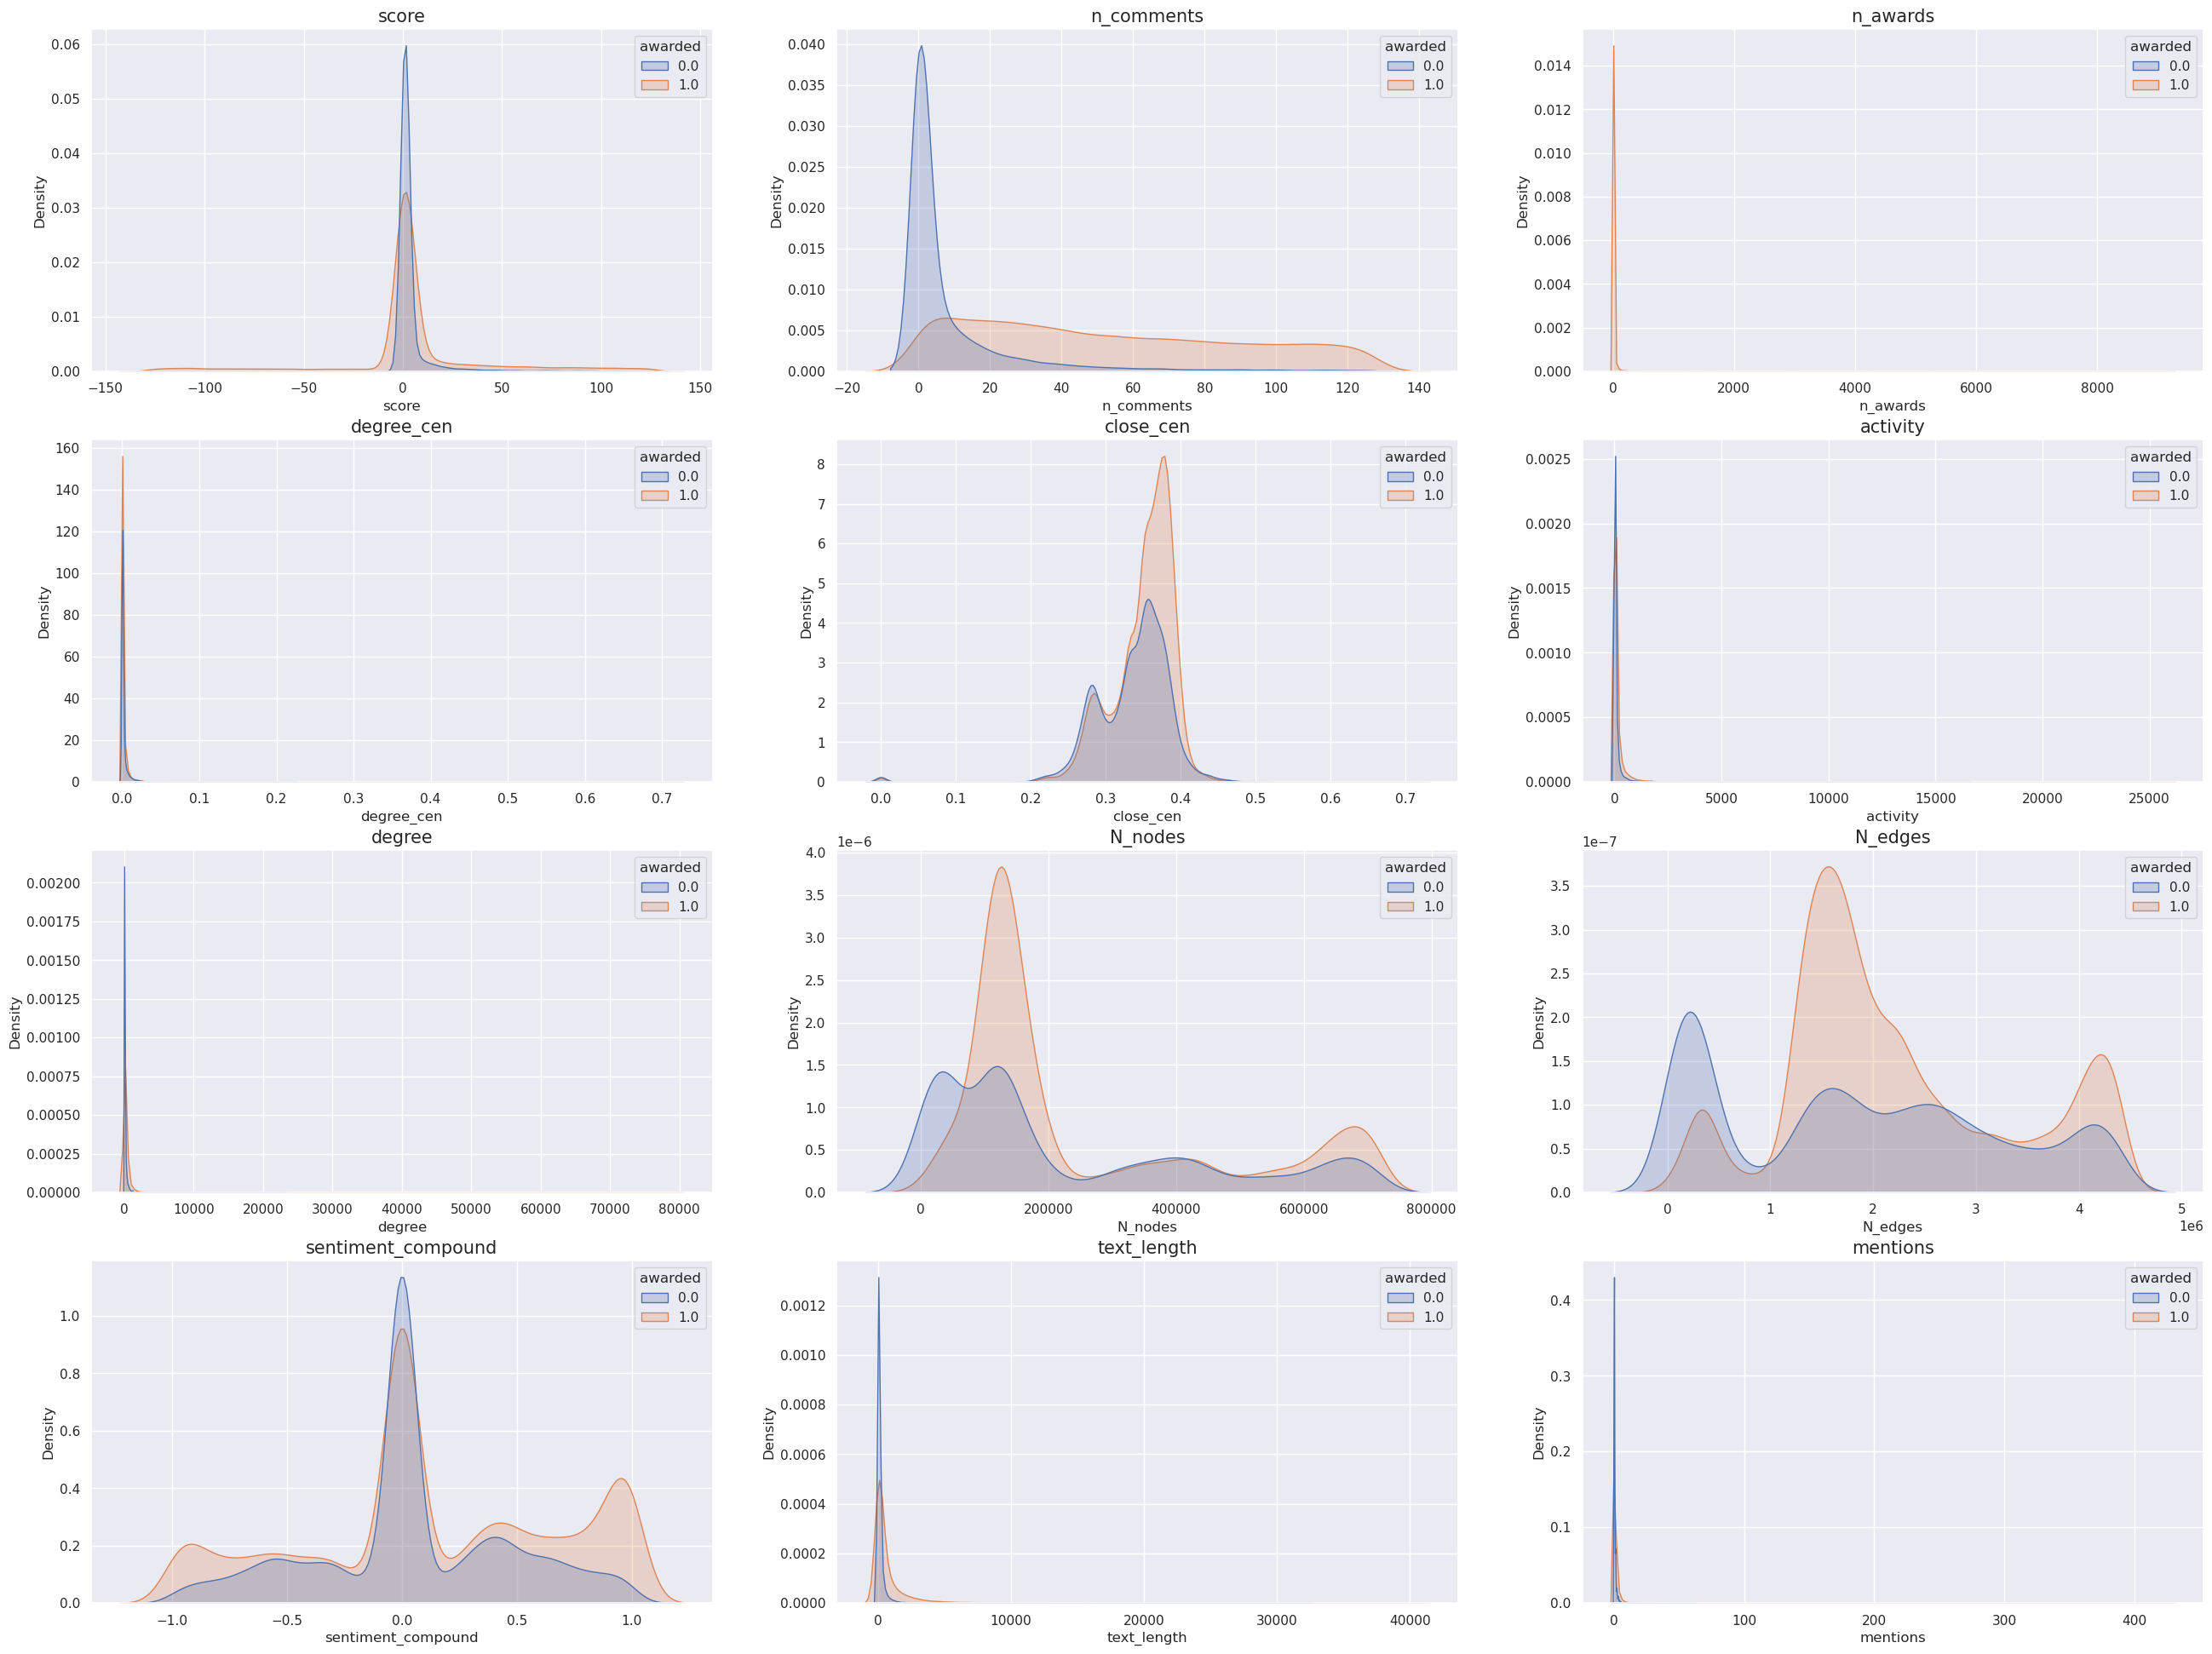

In [13]:
features = ['score', 'n_comments',  'n_awards', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length', 'mentions']

fig, axs = plt.subplots(4, 3, figsize=(8*4,8*3))
axs = axs.flatten()

for i in range(len(features)):
    f = features[i]
    sns.kdeplot(data=df_no, x=f, hue='awarded', fill=True, ax=axs[i])
    axs[i].set_title(f,fontsize=15)

plt.show()

# log and histograms

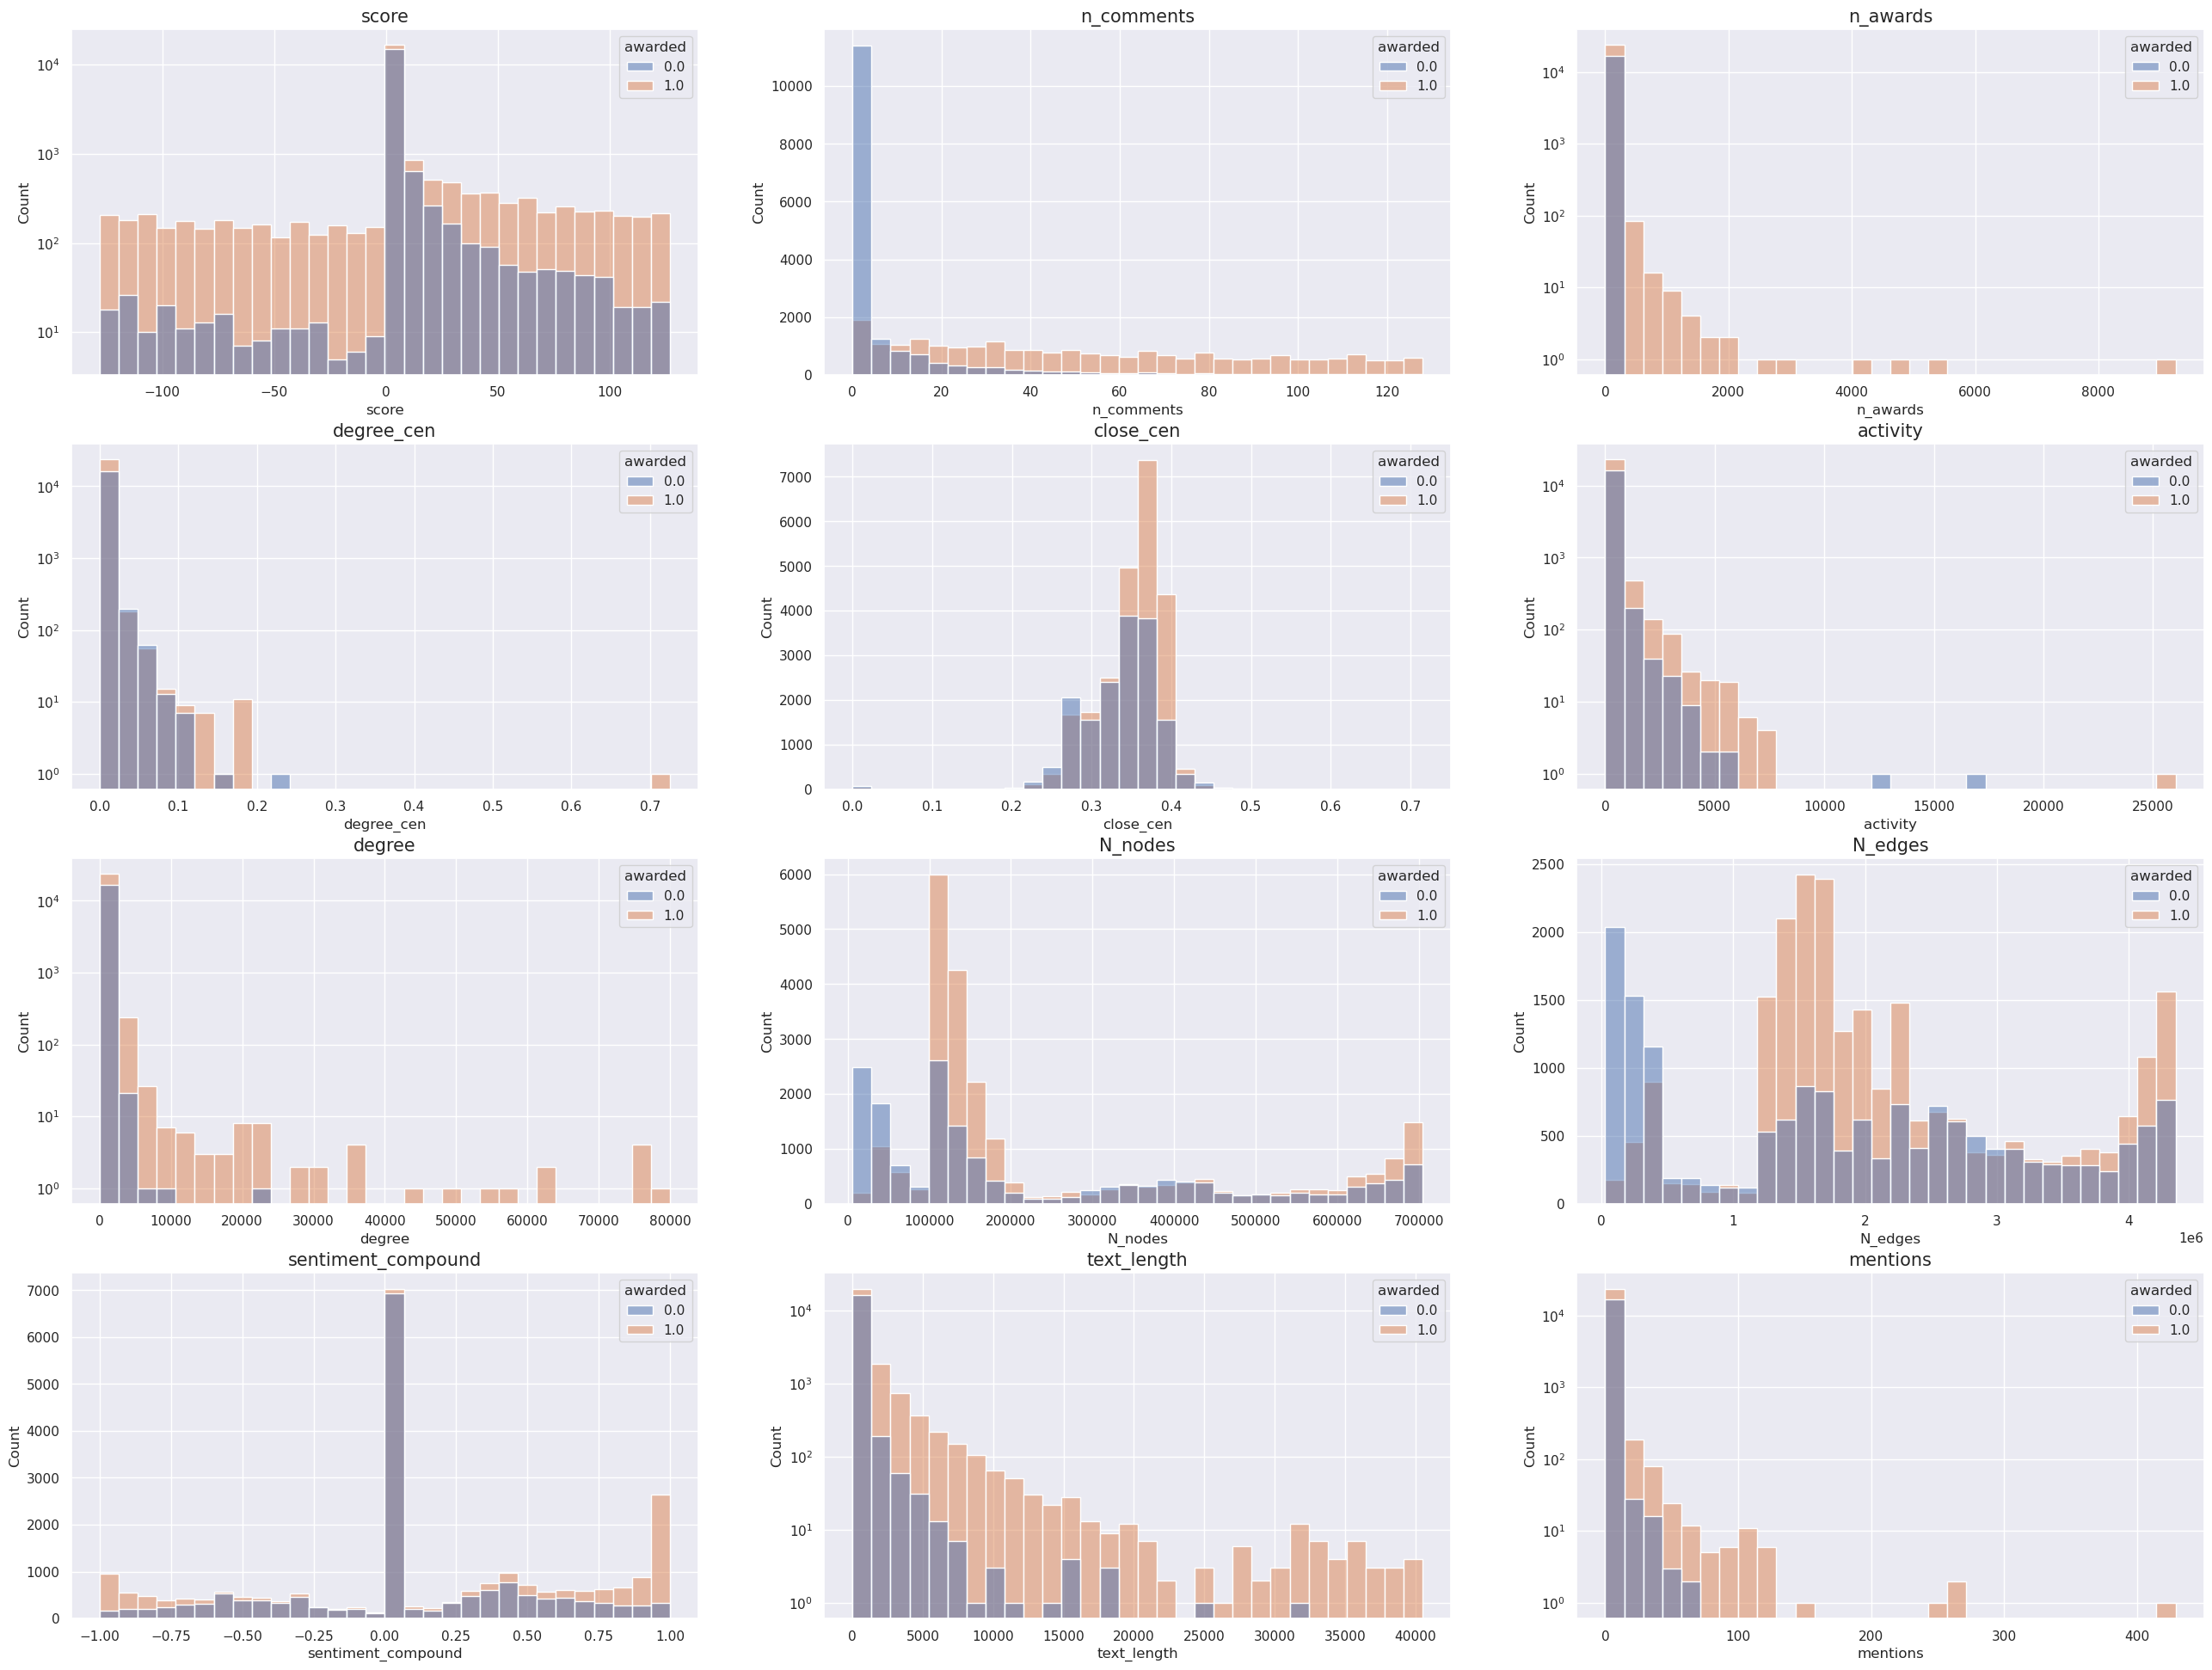

In [14]:
features = ['score', 'n_comments',  'n_awards', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length', 'mentions']
log_features = ['score','n_awards', 'degree_cen', 'activity','degree','text_length','mentions']
fig, axs = plt.subplots(4, 3, figsize=(8*4,8*3))
axs = axs.flatten()

for i in range(len(features)):
    f = features[i]
    if f in log_features:
        sns.histplot(data=df_no, x=f, hue='awarded', ax=axs[i],bins=30)
        axs[i].set_yscale('log')
    else:
        sns.histplot(data=df_no, x=f, hue='awarded', ax=axs[i],bins=30)
    axs[i].set_title(f,fontsize=15)

plt.show()

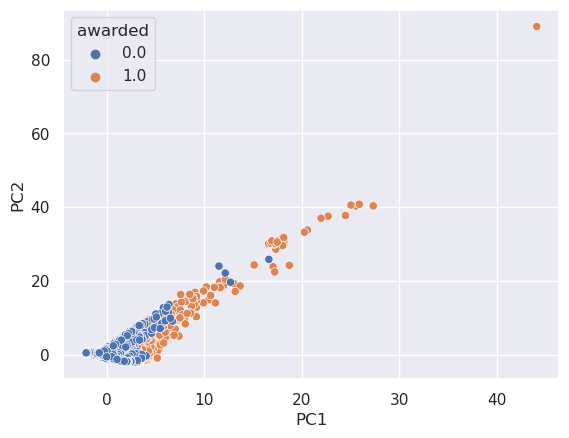

In [15]:
# pca
features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']
scaler = StandardScaler()
scaler.fit(df[features])
df_scaled = scaler.transform(df[features])

pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

df_pca = pd.DataFrame(df_pca,columns=['PC1','PC2'])
df_pca['awarded'] = df['awarded'].values

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='awarded')
plt.show()

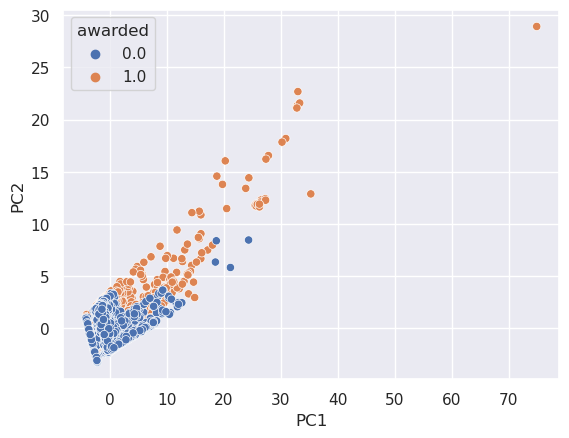

In [16]:
# pca
features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']
scaler = StandardScaler()
scaler.fit(df_no[features])
df_no_scaled = scaler.transform(df_no[features])

pca = PCA(n_components=2)
pca.fit(df_no_scaled)
df_no_pca = pca.transform(df_no_scaled)

df_no_pca = pd.DataFrame(df_no_pca,columns=['PC1','PC2'])
df_no_pca['awarded'] = df_no.awarded.values

sns.scatterplot(data=df_no_pca, x='PC1', y='PC2', hue='awarded')
plt.show()

# Random Forrest

In [17]:
# features = ['score', 'n_comments','degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# # split data into train and test sets
# train, test = train_test_split(df_no, test_size=0.2, random_state=42)

# # split data into X and y
# X_train = train[features]
# y_train = train['awarded']
# X_test = test[features]
# y_test = test['awarded']


# # create model
# rf = RandomForestClassifier(n_estimators=100, random_state=42)

# # fit model
# rf.fit(X_train, y_train)

# # predict
# y_pred = rf.predict(X_test)

# print('F1: ' + str(f1_score(y_test, y_pred.round())))

# # subplot with confussion matrix and feature importance side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
# cm = confusion_matrix(y_test, y_pred.round())
# sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',ax=ax2)
# ax2.set_xlabel('Predicted')
# ax2.set_ylabel('Actual')
# ax2.set_title('Confusion Matrix')

# importance = rf.feature_importances_
# # plot feature importance
# # sort by importance
# idx = np.argsort(importance)
# ax1.barh([x for x in X_train.columns[idx]], importance[idx])
# ax1.tick_params(axis='x', labelrotation = 0)
# ax1.set_title('Feature Importance')

# plt.show()

In [18]:
features = ['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']

F1: 0.7298434004474273
Accuracy: 0.7339619316179062


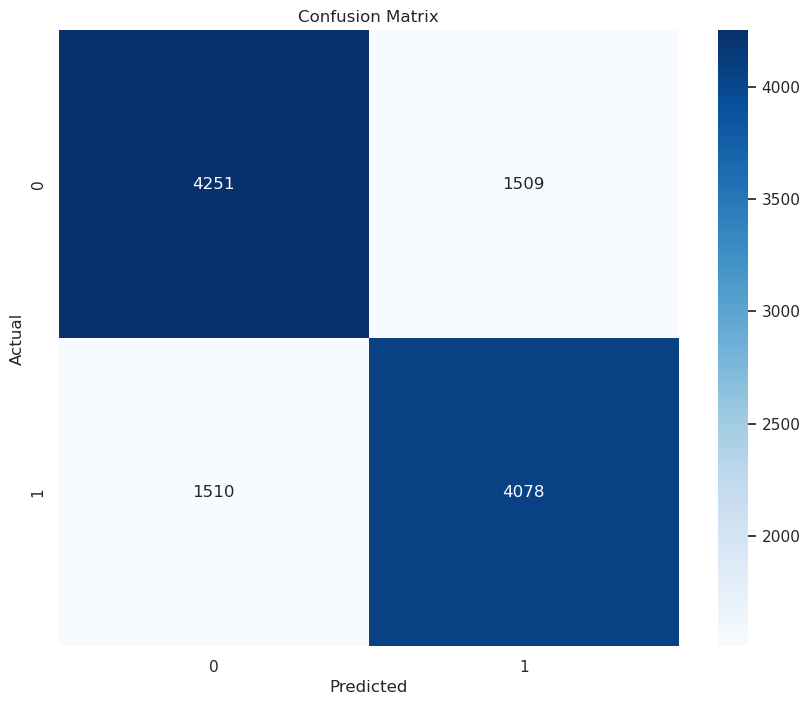

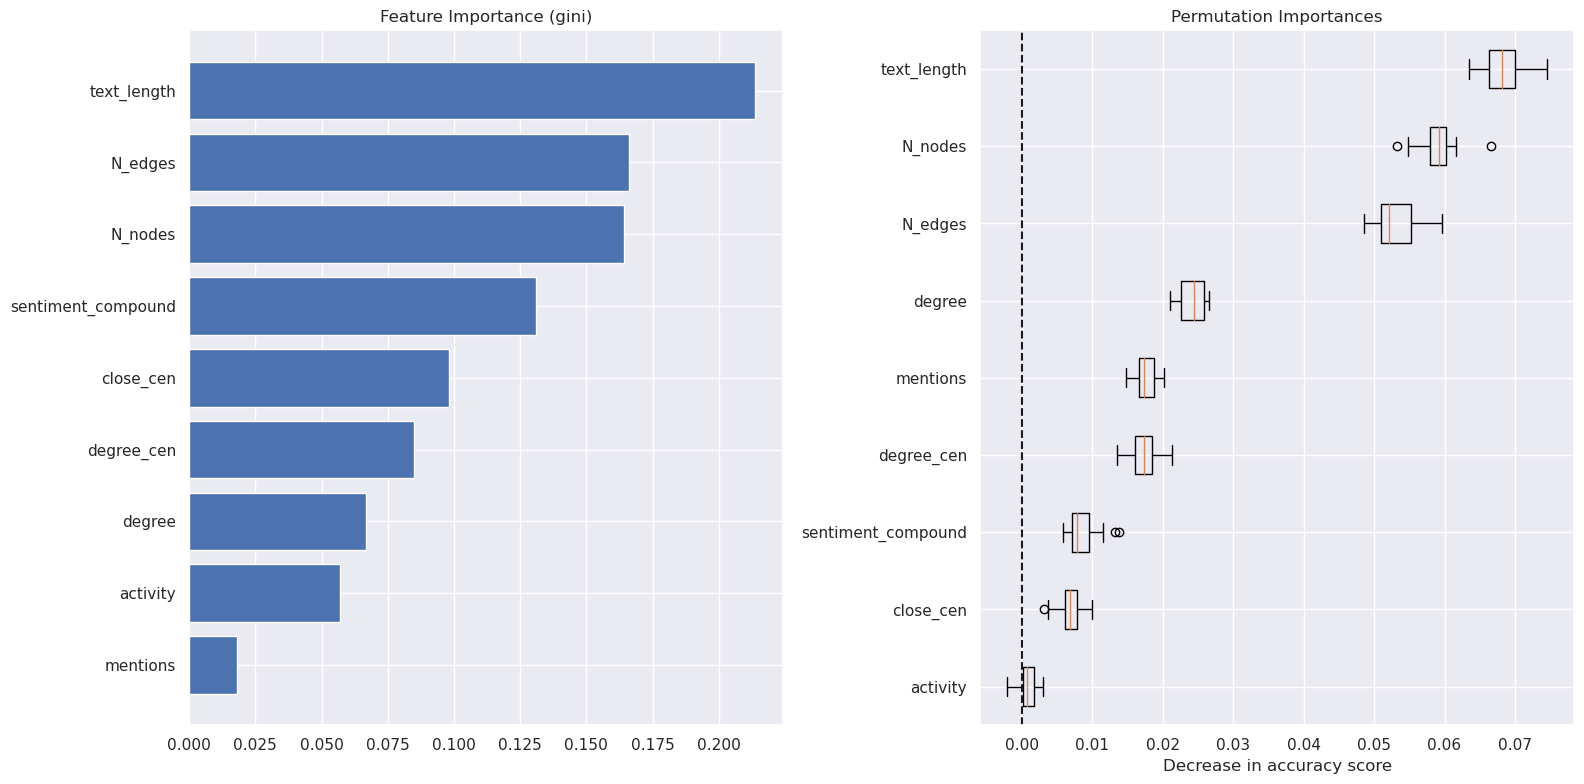

In [19]:
# create model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# fit model
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred.round())))

#Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# permutation importance
result = permutation_importance(rf, X_test, y_test,
                            n_repeats=30,
                            random_state=0)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx])

# subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

importance = rf.feature_importances_
idx = np.argsort(importance)
ax1.barh([x for x in X_train.columns[idx]], importance[idx])
ax1.tick_params(axis='x', labelrotation = 0)
ax1.set_title('Feature Importance (gini)')

# plot permutation importance
ax2.boxplot(importances, vert=False, labels=importances.columns)
ax2.set_title("Permutation Importances")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.figure.tight_layout()

plt.show()

## XGboost

/home/pelle/anaconda3/envs/py39/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


F1: 0.7358767424798239
Accuracy: 0.7462107860415932


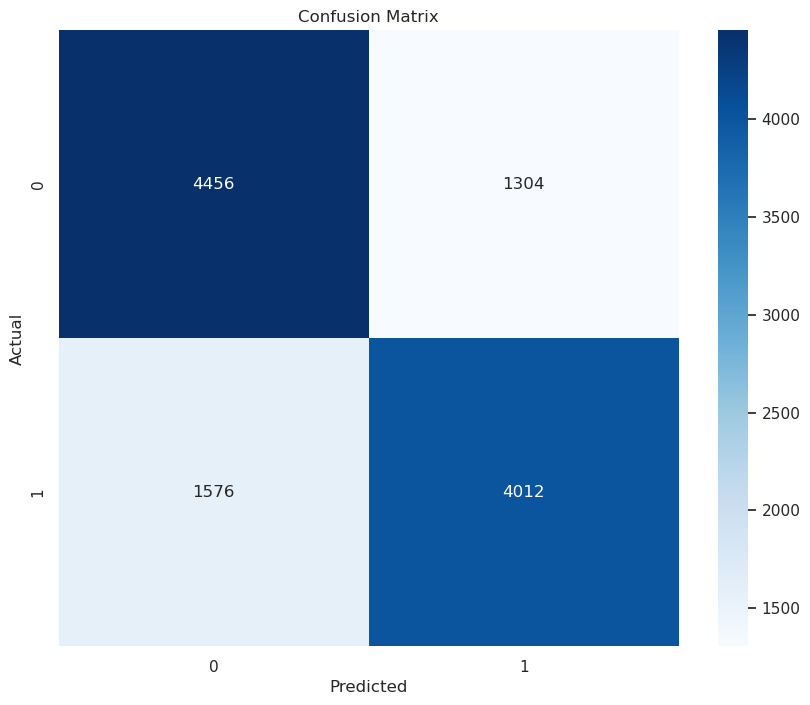

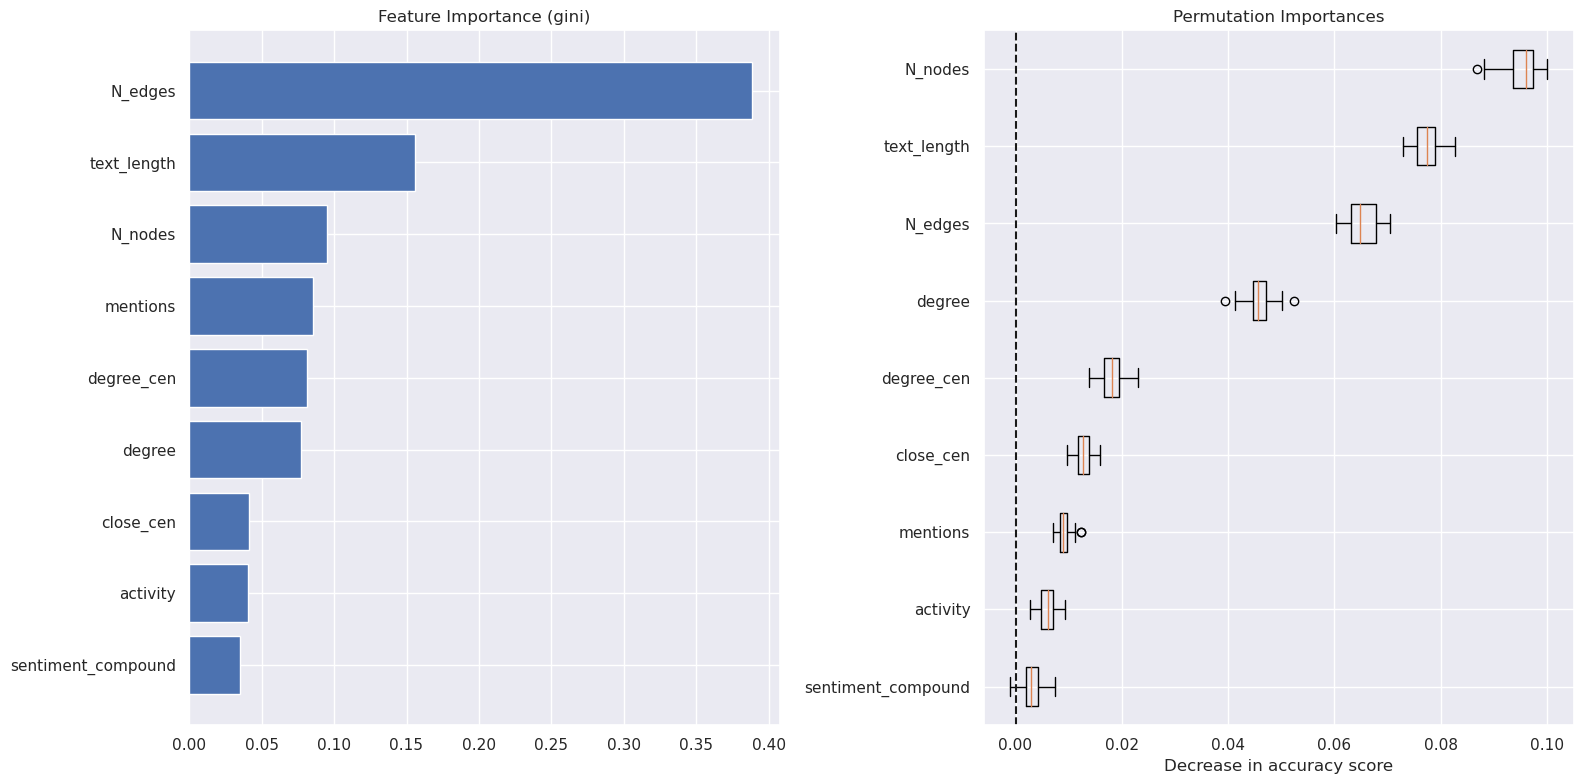

In [20]:
# XGBoost


# create model
from xgboost import XGBClassifier
xgbClass = XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='rmse')

xgbClass.fit(X_train, y_train)

# predict
y_pred = xgbClass.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))
print('Accuracy: ' + str(accuracy_score(y_test, y_pred.round())))

#Confusion Matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# permutation importance
result = permutation_importance(xgbClass, X_test, y_test,
                            n_repeats=30,
                            random_state=0)
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx])

# subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

importance = xgbClass.feature_importances_
idx = np.argsort(importance)
ax1.barh([x for x in X_train.columns[idx]], importance[idx])
ax1.tick_params(axis='x', labelrotation = 0)
ax1.set_title('Feature Importance (gini)')

# plot permutation importance
ax2.boxplot(importances, vert=False, labels=importances.columns)
ax2.set_title("Permutation Importances")
ax2.axvline(x=0, color="k", linestyle="--")
ax2.set_xlabel("Decrease in accuracy score")
ax2.figure.tight_layout()

plt.show()

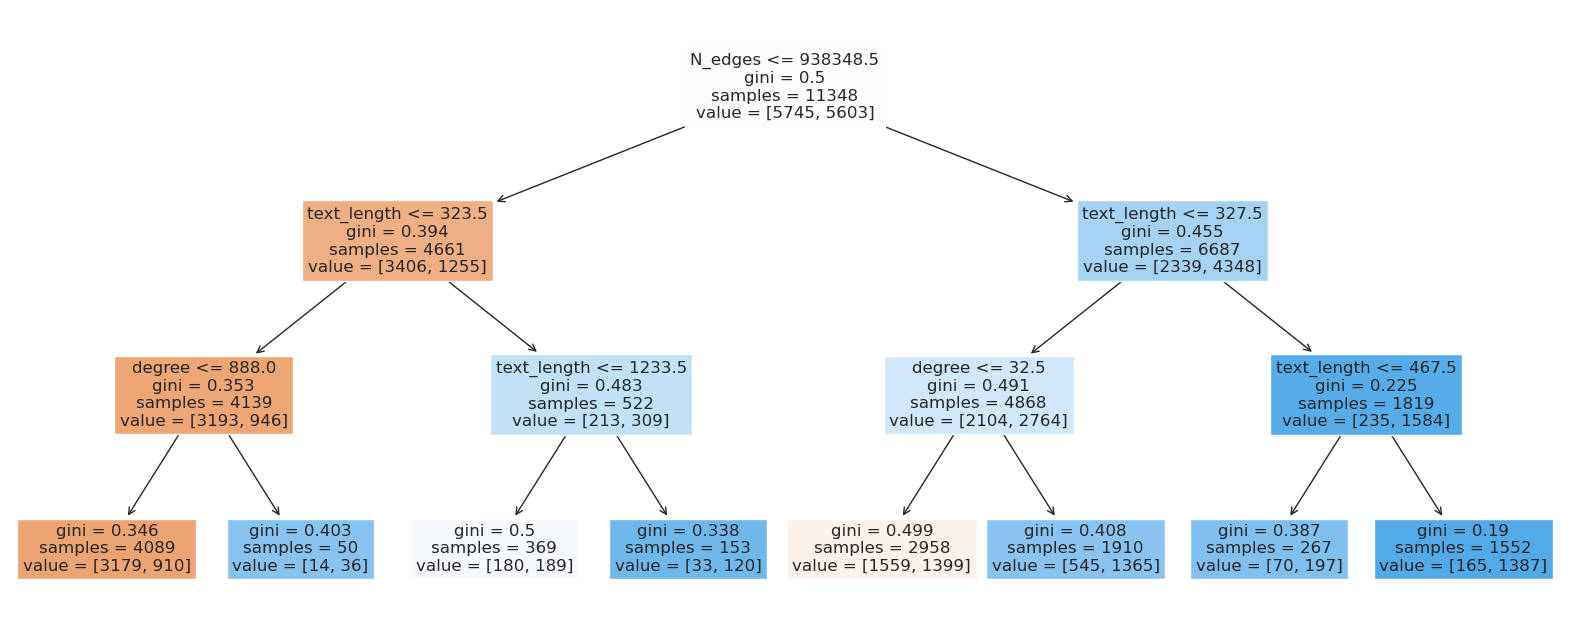

In [21]:
from sklearn import tree

features = ['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']


clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_test, y_test)

plt.figure(figsize=(20,8))
tree.plot_tree(clf, feature_names=features, filled=True, fontsize=12)
plt.show()

In [22]:
# # Too slow..
# # svm
# from sklearn.svm import SVC

# features = ['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# # split data into train and test sets
# train, test = train_test_split(df, test_size=0.2)

# # split data into X and y
# X_train = train[features]
# y_train = train['awarded']
# X_test = test[features]
# y_test = test['awarded']

# # model
# svm = SVC(kernel='linear', C=1.0, random_state=42)

# # fit model
# svm.fit(X_train, y_train)

# # predict
# y_pred = svm.predict(X_test)

# print('F1: ' + str(f1_score(y_test, y_pred.round())))
# print('Accuracy: ' + str(accuracy_score(y_test, y_pred.round())))

# # subplot with confussion matrix and feature importance side by side
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
# cm = confusion_matrix(y_test, y_pred.round())
# sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',ax=ax2)
# ax2.set_xlabel('Predicted')
# ax2.set_ylabel('Actual')
# ax2.set_title('Confusion Matrix')

# importance = svm.coef_[0]
# # plot feature importance
# # sort by importance
# idx = np.argsort(importance)
# ax1.barh([x for x in X_train.columns[idx]], importance[idx])
# ax1.tick_params(axis='x', labelrotation = 0)
# ax1.set_title('Feature Importance')

# plt.show()

# Log reg

F1: 0.658884872903952


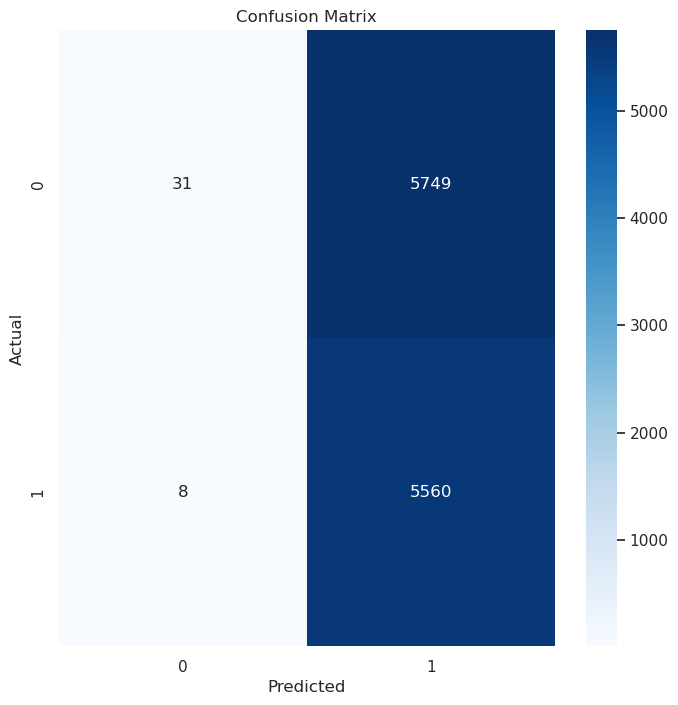

In [23]:
# logistic regression
from sklearn.linear_model import LogisticRegression

features = ['degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['awarded']
X_test = test[features]
y_test = test['awarded']

# create model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# predict
y_pred = logreg.predict(X_test)

print('F1: ' + str(f1_score(y_test, y_pred.round())))


plt.figure(figsize=(8,8))
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Regression model

R2: 0.09003247822774152
RMSE: 104.20637607468272


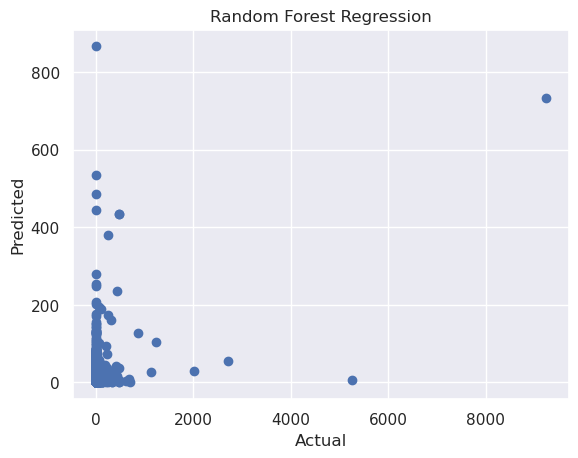

In [24]:
# random forrest regression
from sklearn.ensemble import RandomForestRegressor

features = ['score', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['n_awards']
X_test = test[features]
y_test = test['n_awards']

# create model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# predict
y_pred = rf.predict(X_test)

# calculate mean squared error
print('R2: ' + str(r2_score(y_test, y_pred)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))

#plot 
plt.scatter(x=y_test.values,y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Regression')
plt.show()

R2: -0.027945109870090468
RMSE: 64.24195406718368


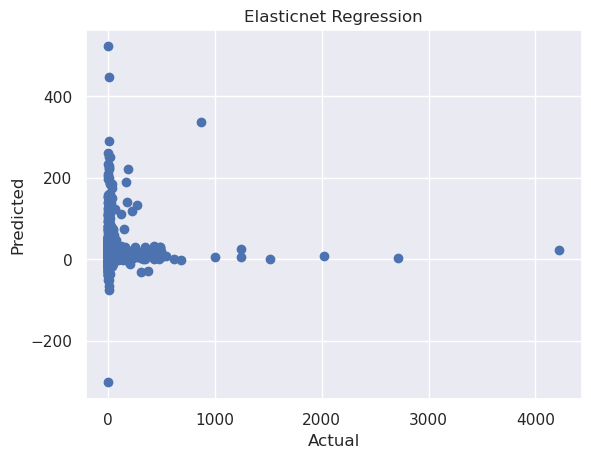

In [25]:
# elastic net regression
from sklearn.linear_model import ElasticNet

features = ['score', 'degree_cen', 'close_cen', 'activity', 'degree', 'N_nodes', 'N_edges', 'sentiment_compound', 'text_length','mentions']

# split data into train and test sets
train, test = train_test_split(df, test_size=0.2)

# split data into X and y
X_train = train[features]
y_train = train['n_awards']
X_test = test[features]
y_test = test['n_awards']

# create model
regr = ElasticNet(random_state=0)
regr.fit(X_train, y_train)

# predict
y_pred = regr.predict(X_test)

# calculate mean squared error
print('R2: ' + str(r2_score(y_test, y_pred)))
print('RMSE: ' + str(np.sqrt(mean_squared_error(y_test, y_pred))))

#plot 
plt.scatter(x=y_test.values,y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Elasticnet Regression')
plt.show()
